In [1]:
import numpy as np

# ! pip install split-folders
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

rs = 42

# Part 1 - Data Preprocessing

## Split into train , test data

In [2]:
IMG_SIZE = 10

In [3]:
# train, test split
splitfolders.ratio('./data/imagesDatabase/', output="./data/humanModel/imagesDatabase_split", ratio=(0.7, 0.3))

Copying files: 43 files [00:00, 933.76 files/s]


### Preprocessing the Training set

In [4]:
batch_size = 8
img_height = 10
img_width = 10

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/train',
  validation_split=0.2,
  subset="training",
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  './data/humanModel/imagesDatabase_split/val',
  validation_split=0.2,
  subset="validation",
  seed=rs,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names
print(class_names)

Found 28 files belonging to 5 classes.
Using 23 files for training.
Found 15 files belonging to 5 classes.
Using 3 files for validation.
['32', '37', '38', '39', '40']


## View some data

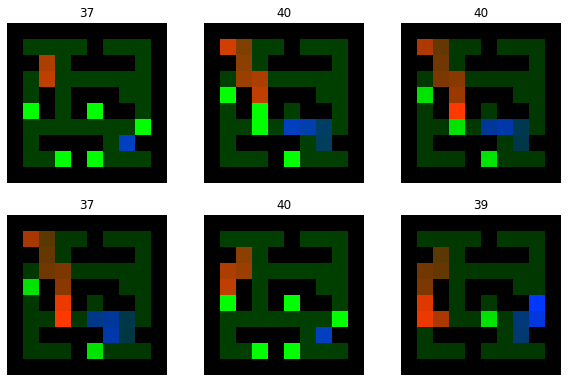

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0

In [10]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
3/3 [==============================] - 0s 51ms/step - loss: 1.6124 - accuracy: 0.0870 - val_loss: 1.5663 - val_accuracy: 0.3333
Epoch 2/30
3/3 [==============================] - 0s 18ms/step - loss: 1.5487 - accuracy: 0.2174 - val_loss: 1.5356 - val_accuracy: 0.3333
Epoch 3/30
3/3 [==============================] - 0s 19ms/step - loss: 1.4587 - accuracy: 0.5217 - val_loss: 1.5023 - val_accuracy: 0.3333
Epoch 4/30
3/3 [==============================] - 0s 22ms/step - loss: 1.3684 - accuracy: 0.5217 - val_loss: 1.4782 - val_accuracy: 0.3333
Epoch 5/30
3/3 [==============================] - 0s 16ms/step - loss: 1.3127 - accuracy: 0.5217 - val_loss: 1.4857 - val_accuracy: 0.3333
Epoch 6/30
3/3 [==============================] - 0s 19ms/step - loss: 1.2400 - accuracy: 0.5217 - val_loss: 1.5511 - val_accuracy: 0.3333
Epoch 7/30
3/3 [==============================] - 0s 18ms/step - loss: 1.2382 - accuracy: 0.5217 - val_loss: 1.6541 - val_accuracy: 0.3333
Epoch 8/30
3/3 [===========

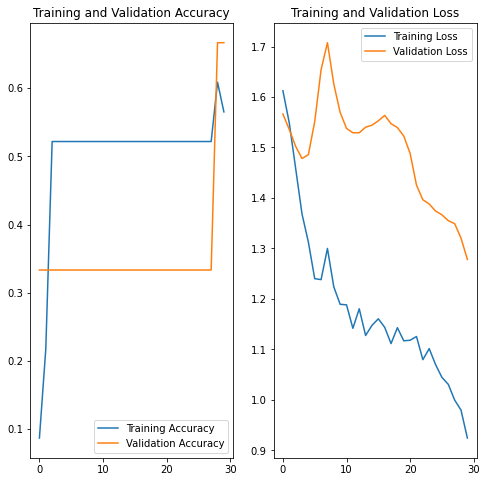

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
print(tf.version.VERSION)

2.3.1


In [16]:
# Save the entire model as a SavedModel.
model.save('./data/humanModel/mode_v0')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./data/humanModel/mode_v0\assets


In [18]:
new_model = tf.keras.models.load_model('./data/humanModel/mode_v0')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 10, 10, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 10, 10, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)          0

### Predict on new data

In [22]:
sunflower_path = "./data/humanModel/imagesDatabase_split/val/37/-MhUR_hORqFZDHLqxzMH_2.png"

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 40 with a 58.56 percent confidence.
